In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
X_train = pickle.load(open('../Data/X_train.pkl', 'rb'))
X_test = pickle.load(open('../Data/X_test.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(329, 20530)
(83, 20530)
(329,)
(83,)


In [5]:
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

train_accuracy_list = []
test_accuracy_list = []
auc_score_list = []
max_acc = -999
optimal_model = None
optimal_n_components = None
optimal_x_train = None
optimal_x_test = None
optimal_predictions = None

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.1, 0.5, 1.0]
}

# components_list = [50, 100, 150, 200, 250, 300, 320]
components_list = np.arange(2, X_train.shape[0])

for n_components in components_list:
    
    # PCA with n_components
    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)

    # Grid Search CV with AdaBoostClassifier
    ada = AdaBoostClassifier(random_state=42)
    gs = GridSearchCV(ada, param_grid, cv=3, n_jobs=-1, verbose=2)   # cv=3 means 3-fold cross validation
    gs.fit(reduced_X_train, y_train)
    model = gs.best_estimator_

    # Evaluation
    train_accuracy = gs.best_score_
    test_accuracy = model.score(reduced_X_test, y_test)
    y_pred_test = model.predict(reduced_X_test)
    auc_score = roc_auc_score(y_test, y_pred_test)

    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    auc_score_list.append(auc_score)

    # for saving the best model
    if test_accuracy > max_acc:
        max_acc = test_accuracy
        optimal_model = model
        optimal_n_components = n_components
        optimal_x_train = reduced_X_train
        optimal_x_test = reduced_X_test
        optimal_predictions = y_pred_test

    print(f"n_components: {n_components}, Train Set Accuracy: {train_accuracy}, Test Set Accuracy: {test_accuracy}, AUC Score: {auc_score}")
    print()

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n_components: 2, Train Set Accuracy: 0.920961912705032, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8689365671641791

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n_components: 3, Train Set Accuracy: 0.9270781206561023, Test Set Accuracy: 0.8795180722891566, AUC Score: 0.8064365671641791

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n_components: 4, Train Set Accuracy: 0.9209897136502642, Test Set Accuracy: 0.927710843373494, AUC Score: 0.8838619402985075

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n_components: 5, Train Set Accuracy: 0.9270781206561023, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n_components: 6, Train Set Accuracy: 0.9301640255768696, Test Set Accuracy: 0.9156626506024096, AUC Score: 0.8763992537313433

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n

In [6]:
print("Best parameters: ", optimal_model.get_params())
print("Optimal n_components: ", optimal_n_components)
print("Best Test Accuracy: ", max_acc)
print("AUC Score: ", roc_auc_score(y_test, optimal_predictions))

Best parameters:  {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 42}
Optimal n_components:  11
Best Test Accuracy:  0.9397590361445783
AUC Score:  0.8913246268656716


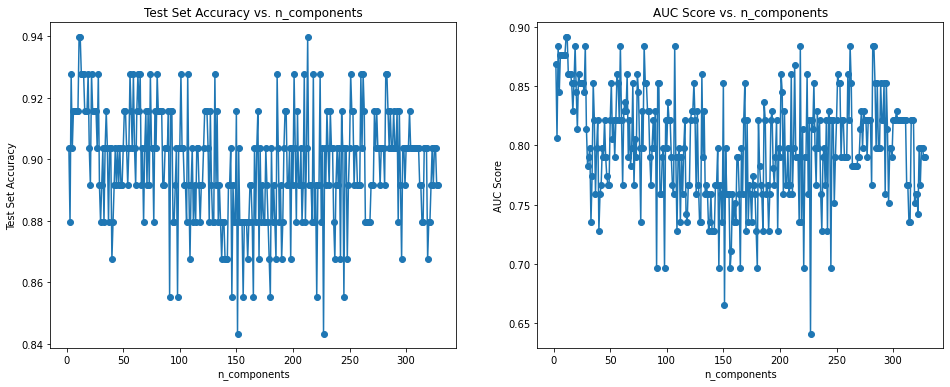

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(components_list, test_accuracy_list, marker='o')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Test Set Accuracy')
ax[0].set_title('Test Set Accuracy vs. n_components')

ax[1].plot(components_list, auc_score_list, marker='o')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('AUC Score')
ax[1].set_title('AUC Score vs. n_components')

plt.show()

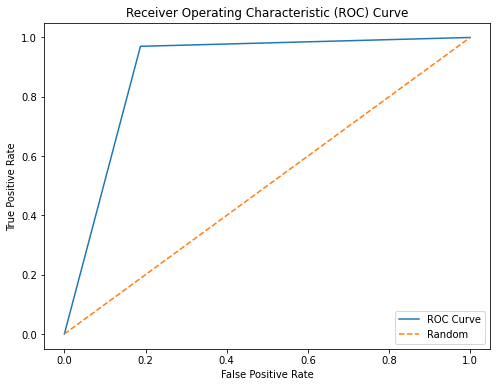

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, optimal_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

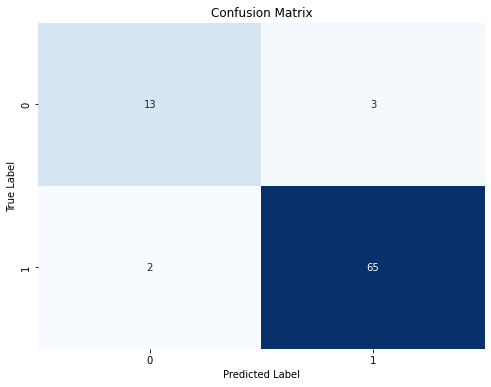

,precision,recall,f1-score,support
0,0.866667,0.812500,0.838710,16.000000
1,0.955882,0.970149,0.962963,67.000000
accuracy,0.939759,0.939759,0.939759,0.939759
macro avg,0.911275,0.891325,0.900836,83.000000
weighted avg,0.938684,0.939759,0.939011,83.000000


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# plot confusion matrix
cm = confusion_matrix(y_test, optimal_predictions)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# print classification report as a df
cr = classification_report(y_test, optimal_predictions, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cr_df

In [13]:
# make a df containing n_components, train_accuracy, test_accuracy, auc_score
res = pd.DataFrame({'n_components': components_list, 'train_accuracy': train_accuracy_list, 'test_accuracy': test_accuracy_list, 'auc_score': auc_score_list})
res

,n_components,train_accuracy,test_accuracy,auc_score
0,2,0.920962,0.903614,0.868937
1,3,0.927078,0.879518,0.806437
2,4,0.920990,0.927711,0.883862
3,5,0.927078,0.903614,0.845149
4,6,0.930164,0.915663,0.876399
...,...,...,...,...
322,324,0.933111,0.891566,0.766325
323,325,0.930081,0.903614,0.797575
324,326,0.930081,0.903614,0.797575
325,327,0.930081,0.891566,0.790112


In [15]:
res.to_csv('pca_adaboost_results.csv', index=True)

In [1]:
import pandas as pd

res = pd.read_csv('pca_adaboost_results.csv', index_col=0)
# extract the best row according to auc_score
best_row = res.iloc[res['auc_score'].idxmax()]
best_row

n_components      11.000000
train_accuracy     0.927050
test_accuracy      0.939759
auc_score          0.891325
Name: 9, dtype: float64

In [16]:
import pickle

dict = {
    'Model': optimal_model,
    'n_components': optimal_n_components,
    'x_train': optimal_x_train,
    'x_test': optimal_x_test,
    'predictions': optimal_predictions,
    'Test Accuracy': max_acc,
    'AUC_score': roc_auc_score(y_test, optimal_predictions)
}

with open('adaboost_PCA.pkl', 'wb') as file:
    pickle.dump(dict, file)

In [18]:
dct = pickle.load(open('adaboost_PCA.pkl', 'rb'))
X_test = dct['x_test']
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_test = dct['Model'].predict(X_test)
acc_score = accuracy_score(y_test, y_pred_test)
auc_score = roc_auc_score(y_test, y_pred_test)

print("Test Accuracy: ", acc_score)
print("AUC Score: ", auc_score)

Test Accuracy:  0.9397590361445783
AUC Score:  0.8913246268656716
